# Sklearn Classification

## Data Preparation

In [7]:
from data_prepare import MultiFormatDataLoader
# Replace the data directory with your actual data path
data_dir = './data'
multi_dataloader = MultiFormatDataLoader(data_dir, batch_size=2048)
multi_dataloader.load_data()

Loading data...


Loading files: 100%|██████████| 8550/8550 [00:06<00:00, 1311.36it/s]


Loaded 8550 samples


In [9]:
multi_dataloader.split_data()

In [10]:
x_train, y_train = multi_dataloader.get_sklearn_data(split='train')
x_val, y_val = multi_dataloader.get_sklearn_data(split='val')
x_test, y_test = multi_dataloader.get_sklearn_data(split='test')

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(x_train, y_train)
y_pred_logreg = logreg.predict(x_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression accuracy:", acc_logreg)

Logistic Regression accuracy: 0.4994152046783626


## KNN

KNN accuracy for n_neighbors=1: 0.5976608187134503
KNN accuracy for n_neighbors=2: 0.6619883040935672
KNN accuracy for n_neighbors=3: 0.6011695906432749
KNN accuracy for n_neighbors=4: 0.6444444444444445
KNN accuracy for n_neighbors=5: 0.6198830409356725
KNN accuracy for n_neighbors=6: 0.6514619883040935
KNN accuracy for n_neighbors=7: 0.6152046783625731
KNN accuracy for n_neighbors=8: 0.6502923976608187
KNN accuracy for n_neighbors=9: 0.6152046783625731
KNN accuracy for n_neighbors=10: 0.6444444444444445


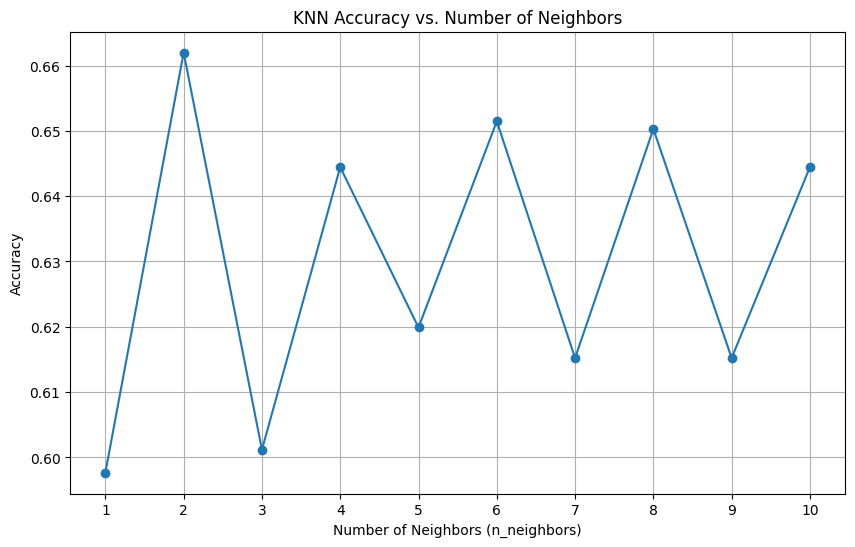

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# Test different n_neighbors
accuracies = []
n_neighbors_range = range(1, 11)
for n in n_neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"KNN accuracy for n_neighbors={n}: {acc}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_range, accuracies, marker='o', linestyle='-')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Accuracy')
plt.xticks(n_neighbors_range)
plt.grid(True)
plt.show()

## SVM

In [ ]:
# TOO SLOW for high-dimensional data

# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# svm_pca = SVC(kernel='linear', random_state=42)
# svm_pca.fit(X_flat_train, y_train)
# y_pred_svm_pca = svm_pca.predict(X_flat_test)
# acc_svm_pca = accuracy_score(y_test, y_pred_svm_pca)
# print(f"SVM (with PCA, 128 components) accuracy: {acc_svm_pca}")

# svm_rbf = SVC(kernel='rbf', random_state=42)
# svm_rbf.fit(X_flat_train, y_train)
# y_pred_svm_rbf = svm_rbf.predict(X_flat_test)
# acc_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
# print("SVM (RBF kernel) accuracy:", acc_svm_rbf)

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest accuracy:", acc_rf)


Random Forest accuracy: 0.7204678362573099


Best parameters: {'max_depth': 40, 'n_estimators': 400}
Best cross-validation accuracy: 0.776608187134503
Test accuracy with best parameters: 0.7637426900584795


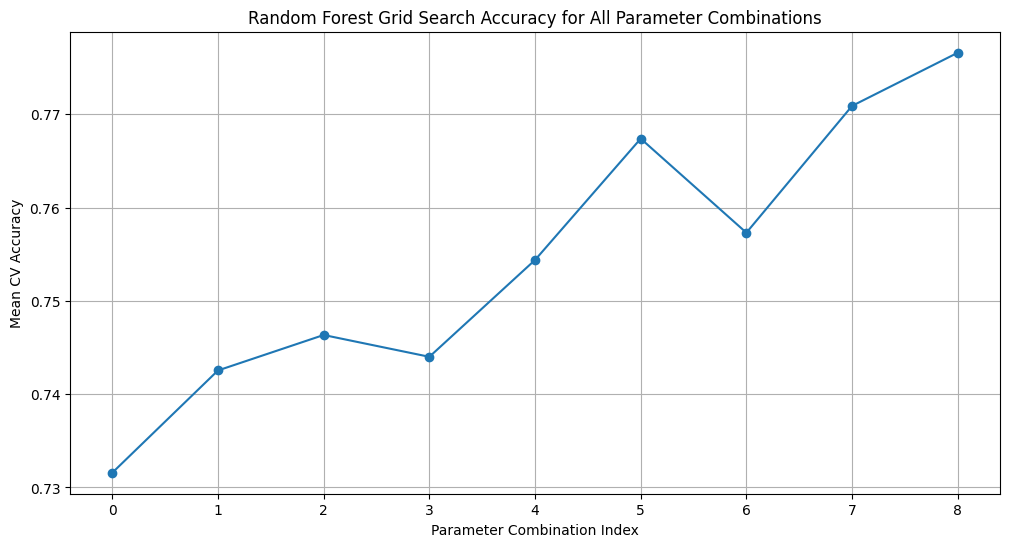

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 40]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Train the model with the best parameters and evaluate
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(x_test)
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Test accuracy with best parameters:", acc_best_rf)

# Visualize the grid search results
results = grid_search.cv_results_
scores = results['mean_test_score']
params = results['params']

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), scores, marker='o')
plt.title('Random Forest Grid Search Accuracy for All Parameter Combinations')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean CV Accuracy')
plt.grid(True)
plt.show()

## Deep Learning

In [2]:
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_model(model_type, input_dim=None):
    import torch.nn as nn
    import torchvision.models as models
    if model_type == 'mlp':
        return nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
                        nn.Linear(64, 2)
        )
    elif model_type == 'logistic':
        return nn.Linear(input_dim, 2)
    elif model_type in ['resnet18', 'resnet50', 'densenet121']:
        class ModelWrapper(nn.Module):
            def __init__(self, model_type):
                super().__init__()
                if model_type == 'resnet18':
                    self.model = models.resnet18(weights=None)
                    self.model.conv1 = nn.Conv2d(20, 64, kernel_size=7, stride=2, padding=3, bias=False)
                    self.model.fc = nn.Linear(self.model.fc.in_features, 2)
                elif model_type == 'resnet50':
                    self.model = models.resnet50(weights=None)
                    self.model.conv1 = nn.Conv2d(20, 64, kernel_size=7, stride=2, padding=3, bias=False)
                    self.model.fc = nn.Linear(self.model.fc.in_features, 2)
                elif model_type == 'densenet121':
                    self.model = models.densenet121(weights=None)
                    self.model.features.conv0 = nn.Conv2d(20, 64, kernel_size=7, stride=2, padding=3, bias=False)
                    self.model.classifier = nn.Linear(self.model.classifier.in_features, 2)
            def forward(self, x):
                assert x.ndim == 4 and x.shape[1] == 20, f"ResNet input shape should be (B, 20, 64, 64), got {x.shape}"
                return self.model(x)
        return ModelWrapper(model_type)
    elif model_type == 'vit':
        from transformers import ViTModel, ViTConfig
        class ViTWrapper(nn.Module):
            def __init__(self):
                super().__init__()
                config = ViTConfig(image_size=64, num_labels=2, num_channels=20, hidden_size=256, num_hidden_layers=6, num_attention_heads=8, intermediate_size=512)
                self.vit = ViTModel(config)
                self.fc = nn.Linear(config.hidden_size, 2)
            def forward(self, x):
                assert x.ndim == 4 and x.shape[1] == 20, f"ViT input shape should be (B, 20, 64, 64), got {x.shape}"
                outputs = self.vit(pixel_values=x)
                pooled = outputs.pooler_output
                return self.fc(pooled)
        return ViTWrapper()
    elif model_type == 'cnn':
        class Simple3DCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
                self.bn1 = nn.BatchNorm3d(16)
                self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
                self.bn2 = nn.BatchNorm3d(32)
                self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
                self.bn3 = nn.BatchNorm3d(64)
                self.relu = nn.ReLU()
                self.pool = nn.MaxPool3d((2,2,2))
                self.global_pool = nn.AdaptiveAvgPool3d((1,1,1))
                self.fc1 = nn.Linear(64, 32)
                self.dropout = nn.Dropout(0.3)
                self.fc2 = nn.Linear(32, 2)
            def forward(self, x):
                # x: (B, 1, 64, 64, 20)
                if x.ndim == 4:
                    x = x.unsqueeze(1)
                assert x.shape[1:] == (1, 64, 64, 20), f"CNN input shape should be (B, 1, 64, 64, 20), got {x.shape}"
                x = self.relu(self.bn1(self.conv1(x)))
                x = self.pool(x)
                x = self.relu(self.bn2(self.conv2(x)))
                x = self.pool(x)
                x = self.relu(self.bn3(self.conv3(x)))
                x = self.global_pool(x)
                x = x.view(x.size(0), -1)
                x = self.dropout(self.relu(self.fc1(x)))
                return self.fc2(x)
        return Simple3DCNN()
    elif model_type in ['rnn', 'gru']:
        class SimpleRNN(nn.Module):
            def __init__(self, hidden_size=128, num_layers=2, bidirectional=True, dropout=0.3):
                super().__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.bidirectional = bidirectional
                rnn_cls = nn.RNN if model_type == 'rnn' else nn.GRU
                self.rnn = rnn_cls(
                    input_size=20,
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    batch_first=True,
                    bidirectional=bidirectional,
                    dropout=dropout if num_layers > 1 else 0.0
                )
                self.fc1 = nn.Linear(hidden_size * (2 if bidirectional else 1), 64)
                self.relu = nn.ReLU()
                self.dropout = nn.Dropout(dropout)
                self.fc2 = nn.Linear(64, 2)
            def forward(self, x):
                # x: (B, 4096, 20)
                if x.ndim == 2:
                    x = x.view(x.size(0), 4096, 20)
                assert x.shape[1:] == (4096, 20), f"RNN input shape should be (B, 4096, 20), got {x.shape}"
                out, _ = self.rnn(x)
                out = out[:, -1, :]
                out = self.relu(self.fc1(out))
                out = self.dropout(out)
                return self.fc2(out)
        return SimpleRNN()
    else:
        raise ValueError('Unknown or unavailable model type: ' + str(model_type))

def train_and_evaluate(model, train_loader, val_loader, test_loader, device, num_epochs=10, lr=1e-3, model_name='model', use_amp=True):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import matplotlib.pyplot as plt
    from tqdm import trange
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler() if use_amp and device.type == 'cuda' else None
    best_val_acc = 0.0
    best_model_path = f'../models/best_{model_name}.pth'
    train_losses = []
    val_accuracies = []
    val_losses = []
    patience = 5
    patience_counter = 0
    for epoch in trange(num_epochs, desc=f"Training {model_name}"):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()  # 确保每个batch都清空梯度
            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    outputs = model(xb)
                    loss = criterion(outputs, yb)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * xb.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += yb.size(0)
            correct_train += (predicted == yb).sum().item()
        avg_train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        # 验证阶段
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                if scaler is not None:
                    with torch.amp.autocast('cuda'):
                        outputs = model(xb)
                        loss = criterion(outputs, yb)
                else:
                    outputs = model(xb)
                    loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = torch.max(outputs, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    # 绘制loss和accuracy曲线
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Test
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    outputs = model(xb)
            else:
                outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    test_acc = correct / total
    print(f"[{model_name}] Test Accuracy of the best model: {test_acc:.4f}")
    return best_val_acc, test_acc


===== Training densenet121 =====
Sample input shape for densenet121: torch.Size([1024, 20, 64, 64])


/tmp/ipykernel_972183/1868522877.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.type == 'cuda' else None
Training densenet121:   0%|          | 0/20 [00:00<?, ?it/s]

[densenet121] Epoch 1/20, Train Loss: 0.6430, Train Acc: 0.6174, Val Loss: 0.6778, Val Acc: 0.5298


Training densenet121:   5%|▌         | 1/20 [00:26<08:27, 26.72s/it]

[densenet121] Epoch 2/20, Train Loss: 0.4840, Train Acc: 0.7855, Val Loss: 0.6710, Val Acc: 0.5708


Training densenet121:  10%|█         | 2/20 [00:47<06:55, 23.09s/it]

[densenet121] Epoch 3/20, Train Loss: 0.3396, Train Acc: 0.8532, Val Loss: 0.5555, Val Acc: 0.7287


Training densenet121:  15%|█▌        | 3/20 [01:13<06:58, 24.64s/it]

[densenet121] Epoch 4/20, Train Loss: 0.1802, Train Acc: 0.9482, Val Loss: 0.5655, Val Acc: 0.7310


Training densenet121:  20%|██        | 4/20 [01:32<05:56, 22.31s/it]

[densenet121] Epoch 5/20, Train Loss: 0.0577, Train Acc: 0.9937, Val Loss: 0.7398, Val Acc: 0.7415


Training densenet121:  30%|███       | 6/20 [02:11<04:44, 20.33s/it]

[densenet121] Epoch 6/20, Train Loss: 0.0155, Train Acc: 0.9997, Val Loss: 0.9397, Val Acc: 0.7298


Training densenet121:  35%|███▌      | 7/20 [02:28<04:09, 19.20s/it]

[densenet121] Epoch 7/20, Train Loss: 0.0058, Train Acc: 1.0000, Val Loss: 1.0364, Val Acc: 0.7345


Training densenet121:  40%|████      | 8/20 [02:43<03:34, 17.86s/it]

[densenet121] Epoch 8/20, Train Loss: 0.0034, Train Acc: 1.0000, Val Loss: 1.0699, Val Acc: 0.7345


Training densenet121:  45%|████▌     | 9/20 [02:58<03:08, 17.10s/it]

[densenet121] Epoch 9/20, Train Loss: 0.0019, Train Acc: 1.0000, Val Loss: 1.1108, Val Acc: 0.7251


Training densenet121:  45%|████▌     | 9/20 [03:14<03:57, 21.59s/it]

[densenet121] Epoch 10/20, Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 1.1035, Val Acc: 0.7357
Early stopping at epoch 10


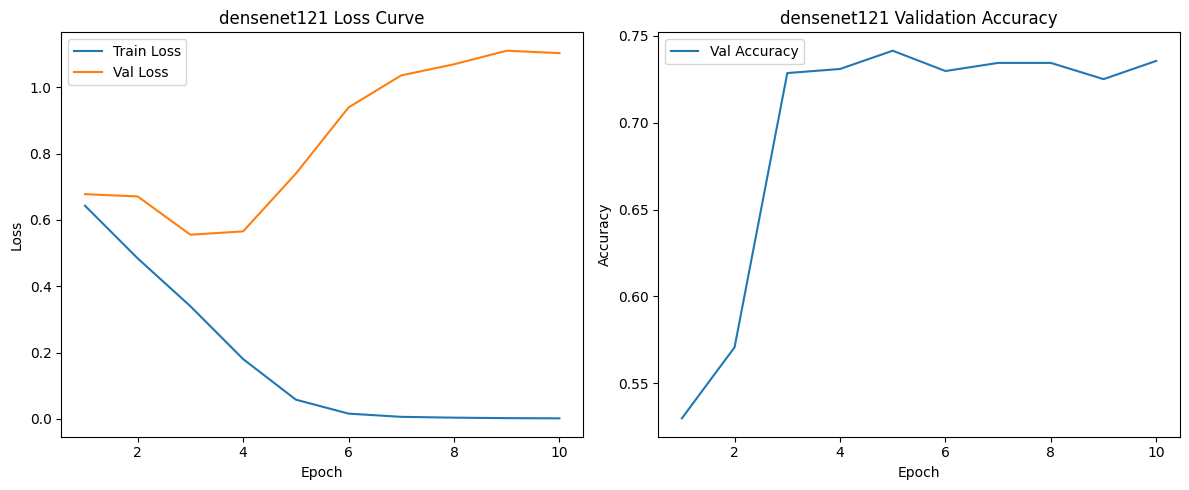

[densenet121] Test Accuracy of the best model: 0.7135

===== Training resnet18 =====
Sample input shape for resnet18: torch.Size([1024, 20, 64, 64])


Training resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

[resnet18] Epoch 1/10, Train Loss: 0.6058, Train Acc: 0.6665, Val Loss: 1.0097, Val Acc: 0.5509


Training resnet18:  10%|█         | 1/10 [00:27<04:05, 27.30s/it]

[resnet18] Epoch 2/10, Train Loss: 0.3836, Train Acc: 0.8323, Val Loss: 0.5486, Val Acc: 0.7181


Training resnet18:  20%|██        | 2/10 [00:52<03:29, 26.16s/it]

[resnet18] Epoch 3/10, Train Loss: 0.1733, Train Acc: 0.9468, Val Loss: 0.6394, Val Acc: 0.7216


Training resnet18:  30%|███       | 3/10 [01:17<02:59, 25.63s/it]

[resnet18] Epoch 4/10, Train Loss: 0.0376, Train Acc: 0.9943, Val Loss: 0.8978, Val Acc: 0.7368


Training resnet18:  50%|█████     | 5/10 [01:56<01:47, 21.53s/it]

[resnet18] Epoch 5/10, Train Loss: 0.0107, Train Acc: 0.9978, Val Loss: 1.1007, Val Acc: 0.7287


Training resnet18:  60%|██████    | 6/10 [02:12<01:18, 19.63s/it]

[resnet18] Epoch 6/10, Train Loss: 0.0045, Train Acc: 0.9994, Val Loss: 1.2435, Val Acc: 0.7368


Training resnet18:  70%|███████   | 7/10 [02:29<00:55, 18.49s/it]

[resnet18] Epoch 7/10, Train Loss: 0.0029, Train Acc: 0.9997, Val Loss: 1.3729, Val Acc: 0.7345
[resnet18] Epoch 8/10, Train Loss: 0.0015, Train Acc: 1.0000, Val Loss: 1.3570, Val Acc: 0.7404


Training resnet18:  90%|█████████ | 9/10 [03:10<00:19, 19.16s/it]

[resnet18] Epoch 9/10, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 1.3627, Val Acc: 0.7345


Training resnet18: 100%|██████████| 10/10 [03:25<00:00, 20.58s/it]

[resnet18] Epoch 10/10, Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 1.3586, Val Acc: 0.7357


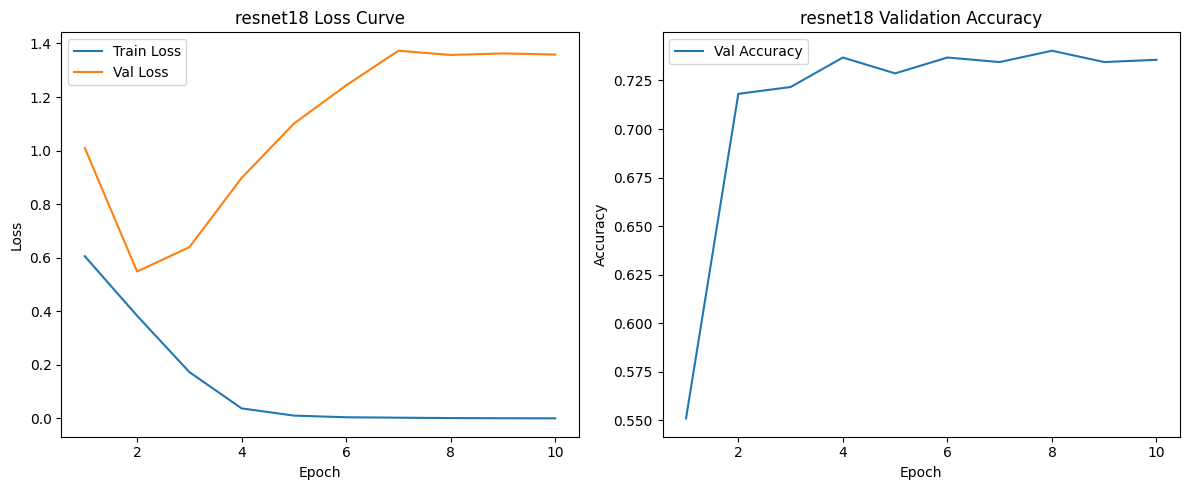

[resnet18] Test Accuracy of the best model: 0.7567

===== Training mlp =====
Sample input shape for mlp: torch.Size([1024, 81920])


Training mlp:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 1/20, Train Loss: 0.6290, Train Acc: 0.6478, Val Loss: 0.7854, Val Acc: 0.5965


Training mlp:  10%|█         | 2/20 [00:39<05:43, 19.10s/it]

[mlp] Epoch 2/20, Train Loss: 0.5020, Train Acc: 0.7620, Val Loss: 0.7526, Val Acc: 0.5708
[mlp] Epoch 3/20, Train Loss: 0.3913, Train Acc: 0.8232, Val Loss: 0.7186, Val Acc: 0.6000


Training mlp:  15%|█▌        | 3/20 [01:53<12:36, 44.48s/it]

[mlp] Epoch 4/20, Train Loss: 0.2566, Train Acc: 0.8993, Val Loss: 0.7147, Val Acc: 0.6725


Training mlp:  20%|██        | 4/20 [03:14<15:37, 58.59s/it]

[mlp] Epoch 5/20, Train Loss: 0.1514, Train Acc: 0.9434, Val Loss: 0.8518, Val Acc: 0.6772


Training mlp:  25%|██▌       | 5/20 [04:35<16:40, 66.70s/it]

[mlp] Epoch 6/20, Train Loss: 0.1109, Train Acc: 0.9572, Val Loss: 1.0644, Val Acc: 0.6842


Training mlp:  30%|███       | 6/20 [05:50<16:16, 69.73s/it]

[mlp] Epoch 7/20, Train Loss: 0.0821, Train Acc: 0.9687, Val Loss: 1.1376, Val Acc: 0.7041


Training mlp:  40%|████      | 8/20 [07:25<10:57, 54.75s/it]

[mlp] Epoch 8/20, Train Loss: 0.0698, Train Acc: 0.9766, Val Loss: 1.2449, Val Acc: 0.6994


Training mlp:  45%|████▌     | 9/20 [07:42<07:53, 43.01s/it]

[mlp] Epoch 9/20, Train Loss: 0.0648, Train Acc: 0.9750, Val Loss: 1.3444, Val Acc: 0.6842


Training mlp:  50%|█████     | 10/20 [07:59<05:49, 34.96s/it]

[mlp] Epoch 10/20, Train Loss: 0.0577, Train Acc: 0.9784, Val Loss: 1.4069, Val Acc: 0.6889


Training mlp:  55%|█████▌    | 11/20 [08:16<04:23, 29.30s/it]

[mlp] Epoch 11/20, Train Loss: 0.0510, Train Acc: 0.9810, Val Loss: 1.4482, Val Acc: 0.6924


Training mlp:  55%|█████▌    | 11/20 [08:32<06:58, 46.55s/it]

[mlp] Epoch 12/20, Train Loss: 0.0550, Train Acc: 0.9788, Val Loss: 1.4933, Val Acc: 0.6912
Early stopping at epoch 12


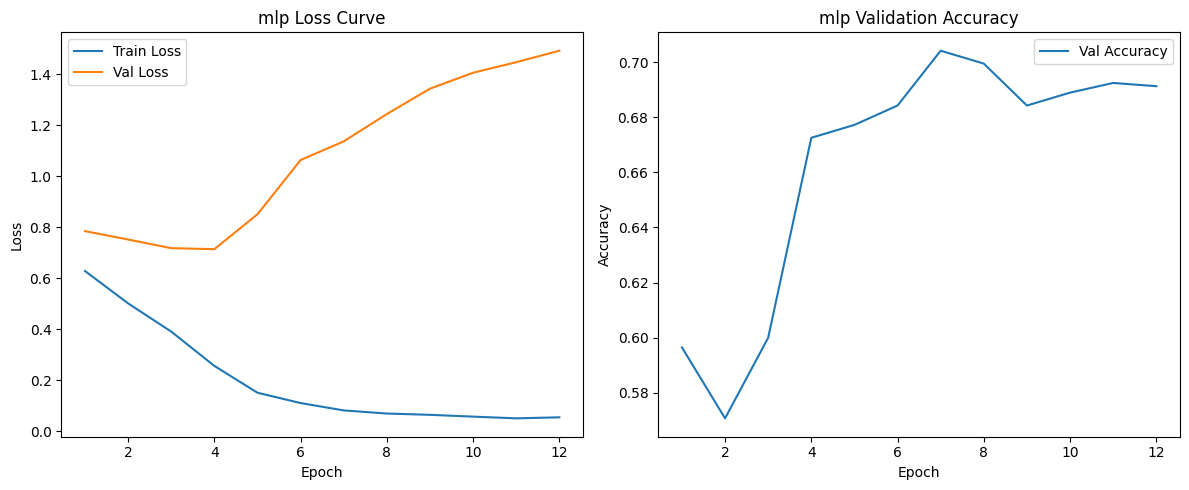

[mlp] Test Accuracy of the best model: 0.7123

===== Training cnn =====
Sample input shape for cnn: torch.Size([1024, 1, 64, 64, 20])


Training cnn:   6%|▌         | 1/18 [00:22<06:27, 22.80s/it]

[cnn] Epoch 1/18, Train Loss: 0.7017, Train Acc: 0.4908, Val Loss: 0.6911, Val Acc: 0.6187


Training cnn:  11%|█         | 2/18 [00:42<05:37, 21.09s/it]

[cnn] Epoch 2/18, Train Loss: 0.6899, Train Acc: 0.5373, Val Loss: 0.6859, Val Acc: 0.5532


Training cnn:  17%|█▋        | 3/18 [01:01<05:02, 20.15s/it]

[cnn] Epoch 3/18, Train Loss: 0.6774, Train Acc: 0.6158, Val Loss: 0.6785, Val Acc: 0.4959


Training cnn:  22%|██▏       | 4/18 [01:22<04:44, 20.34s/it]

[cnn] Epoch 4/18, Train Loss: 0.6465, Train Acc: 0.7257, Val Loss: 0.6682, Val Acc: 0.4749
[cnn] Epoch 5/18, Train Loss: 0.6116, Train Acc: 0.7439, Val Loss: 0.6185, Val Acc: 0.6339


Training cnn:  33%|███▎      | 6/18 [02:01<03:58, 19.90s/it]

[cnn] Epoch 6/18, Train Loss: 0.5774, Train Acc: 0.7513, Val Loss: 0.5476, Val Acc: 0.7789


Training cnn:  39%|███▉      | 7/18 [02:21<03:39, 19.98s/it]

[cnn] Epoch 7/18, Train Loss: 0.5403, Train Acc: 0.7694, Val Loss: 0.5171, Val Acc: 0.7696


Training cnn:  44%|████▍     | 8/18 [02:43<03:26, 20.63s/it]

[cnn] Epoch 8/18, Train Loss: 0.5053, Train Acc: 0.7791, Val Loss: 0.5362, Val Acc: 0.7345


Training cnn:  50%|█████     | 9/18 [03:04<03:05, 20.61s/it]

[cnn] Epoch 9/18, Train Loss: 0.4780, Train Acc: 0.7885, Val Loss: 0.8033, Val Acc: 0.6035


Training cnn:  56%|█████▌    | 10/18 [03:23<02:42, 20.26s/it]

[cnn] Epoch 10/18, Train Loss: 0.4635, Train Acc: 0.7921, Val Loss: 0.6586, Val Acc: 0.6772


Training cnn:  56%|█████▌    | 10/18 [03:43<02:58, 22.31s/it]

[cnn] Epoch 11/18, Train Loss: 0.4433, Train Acc: 0.8032, Val Loss: 0.5971, Val Acc: 0.7123
Early stopping at epoch 11


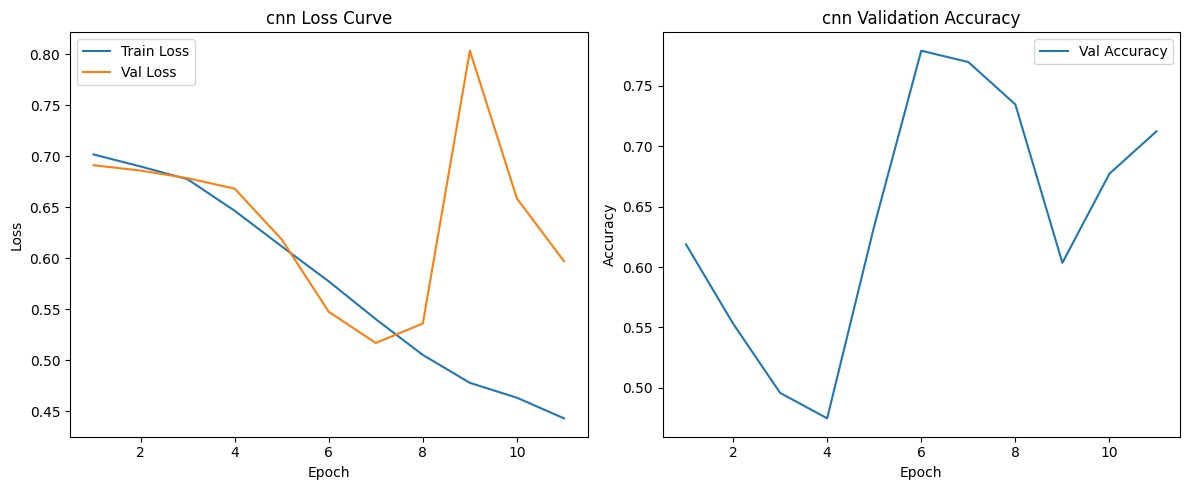

[cnn] Test Accuracy of the best model: 0.7977

Model Performance Comparison:
densenet121: Validation Accuracy = 0.7415204678362574, Test Accuracy = 0.7134502923976608
resnet18: Validation Accuracy = 0.7403508771929824, Test Accuracy = 0.7567251461988304
mlp: Validation Accuracy = 0.704093567251462, Test Accuracy = 0.712280701754386
cnn: Validation Accuracy = 0.7789473684210526, Test Accuracy = 0.7976608187134503


In [4]:
model_hyperparams = {
    'densenet121':{'num_epochs': 20, 'lr': 2e-4},
    'resnet18':  {'num_epochs': 10, 'lr': 2e-4},
    # 'resnet50':  {'num_epochs': 20, 'lr': 2e-4},
    # 'vit':       {'num_epochs': 12, 'lr': 5e-5},
    # 'rnn':       {'num_epochs': 15, 'lr': 1e-3},
    # 'gru':       {'num_epochs': 15, 'lr': 1e-3},
    'mlp':        {'num_epochs': 20, 'lr': 1e-3},
    # 'logistic':  {'num_epochs': 8,  'lr': 5e-2},
    'cnn':     {'num_epochs': 18, 'lr': 1e-3},
}

test_results = {}
for model_type in model_hyperparams.keys():
    print(f'\n===== Training {model_type} =====')
    try:
        params = model_hyperparams.get(model_type, {'num_epochs': 10, 'lr': 1e-3})
        if model_type in ['mlp', 'logistic']:
            model = get_model(model_type, input_dim=X_flat_train.shape[1])
        else:
            model = get_model(model_type)
        # 检查dataloader输出shape
        sample_batch = next(iter(train_loaders[model_type]))
        xb, yb = sample_batch[0], sample_batch[1]
        print(f"Sample input shape for {model_type}: {xb.shape}")
        # 检查模型forward
        try:
            model(xb[:2])
        except Exception as e:
            print(f"Model {model_type} forward error: {e}")
            raise
        val_acc, test_acc = train_and_evaluate(
            model,
            train_loaders[model_type],
            val_loaders[model_type],
            test_loaders[model_type],
            device,
            num_epochs=params['num_epochs'],
            lr=params['lr'],
            model_name=model_type,
            use_amp=True
        )
        test_results[model_type] = {'val_acc': val_acc, 'test_acc': test_acc}
    except Exception as e:
        print(f"Model {model_type} failed: {e}")
        test_results[model_type] = {'val_acc': None, 'test_acc': None}

print("\nModel Performance Comparison:")
for k, v in test_results.items():
    print(f"{k}: Validation Accuracy = {v['val_acc']}, Test Accuracy = {v['test_acc']}")


[Eval] Loading best_densenet121.pth ...
[Eval] densenet121 Test Accuracy: 0.7146

[Eval] Loading best_resnet18.pth ...
[Eval] resnet18 Test Accuracy: 0.7567

[Eval] Loading best_mlp.pth ...
[Eval] mlp Test Accuracy: 0.7123

[Eval] Loading best_cnn.pth ...
[Eval] cnn Test Accuracy: 0.7977


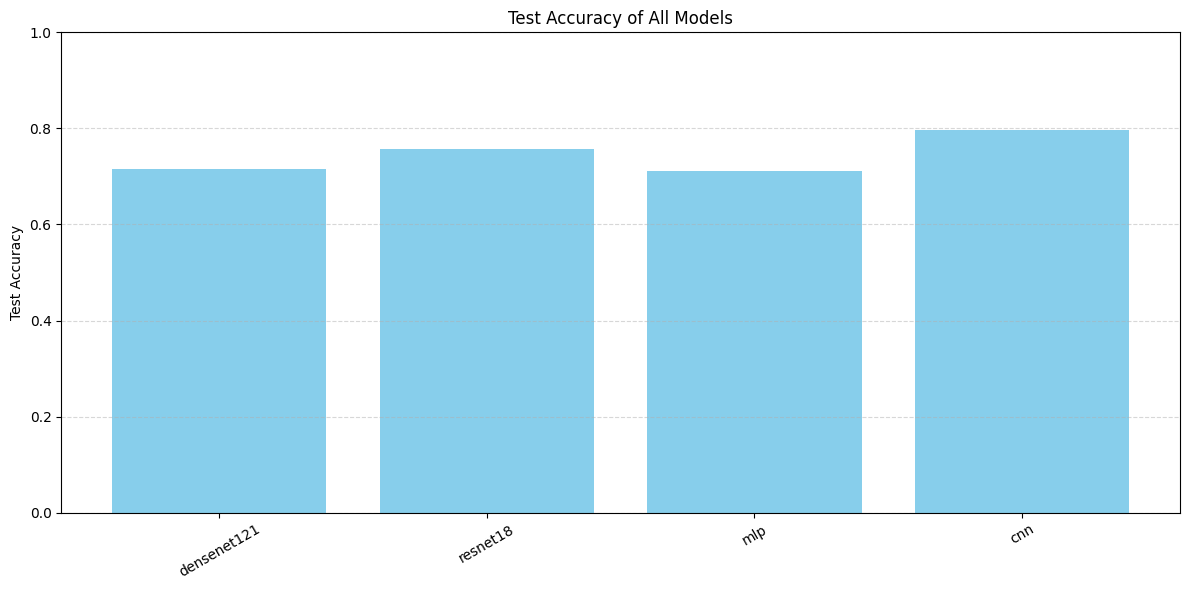

In [5]:
import matplotlib.pyplot as plt

model_names = list(test_results.keys())
test_accs = []
for model_type in model_names:
    try:
        print(f"\n[Eval] Loading best_{model_type}.pth ...")
        if model_type in ['mlp', 'logistic']:
            model = get_model(model_type, input_dim=X_flat_train.shape[1])
        else:
            model = get_model(model_type)
        model.load_state_dict(torch.load(f'../models/best_{model_type}.pth', map_location=device))
        model = model.to(device)
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for xb, yb in test_loaders[model_type]:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()
                all_preds.append(predicted.cpu().numpy())
                all_labels.append(yb.cpu().numpy())
        acc = correct / total
        test_accs.append(acc)
        print(f"[Eval] {model_type} Test Accuracy: {acc:.4f}")
    except Exception as e:
        print(f"[Eval] {model_type} failed: {e}")
        test_accs.append(None)

plt.figure(figsize=(12,6))
plt.bar(model_names, [a if a is not None else 0 for a in test_accs], color='skyblue')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of All Models')
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()